Some Test prototype

In [177]:
import pickle
with open("../../resources/seasonal-model.pkl", "rb") as f:
    mmm = pickle.load(f)

In [178]:
import numpy as np
import pandas as pd
from karpiu.explainability import AttributorGamma

In [179]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [180]:
df = mmm.get_raw_df()
channels = mmm.get_spend_cols()

attr_start = "2020-01-01"
attr_end = "2020-01-15"
duration = (pd.to_datetime(attr_end) - pd.to_datetime(attr_start)).days + 1

# check attribution works with full set and subset of channels
# for ch_subset in channels_subsets:
#     attr_obj = AttributorBeta(
#         mmm,
#         attr_regressors=ch_subset,
#         start="2020-01-01",
#         end="2020-01-31",
#     )

#     res = attr_obj.make_attribution(fixed_intercept=False)
#     activities_attr_df, spend_attr_df, spend_df, cost_df = res

#     assert activities_attr_df.shape[0] == duration
#     assert (activities_attr_df.shape[1] - 2) == len(ch_subset)
#     assert spend_attr_df.shape[0] == duration
#     assert (spend_attr_df.shape[1] - 2) == len(ch_subset)
#     assert cost_df.shape[0] == duration

#     # in no adstock case, activities and spend attribution should be identical
#     assert np.all(
#         np.equal(
#             activities_attr_df[["organic"] + ch_subset].values,
#             spend_attr_df[["organic"] + ch_subset].values,
#         )
#     )

# in single step, compare with prediction delta to make sure the one-of is calculated
# correctly


In [127]:
# original df
attributor = AttributorGamma(
    mmm,
    start=attr_start,
    end=attr_end,
    debug=True
)
activities_attr_df, spend_attr_df, spend_df, cost_df = attributor.make_attribution()

assert activities_attr_df.shape[0] == duration
assert spend_attr_df.shape[0] == duration

# assert np.all(activities_attr_df[['organic'] + mmm.get_spend_cols()].sum() == spend_attr_df[['organic'] + mmm.get_spend_cols()].sum())

# increase spend df
new_df = mmm.get_raw_df()
new_df['search'] *= 10
new_attributor = AttributorGamma(
    mmm,
    df=new_df,
    start=attr_start,
    end=attr_end,
    debug=True
)
new_activities_attr_df, new_spend_attr_df, new_spend_df, new_cost_df = new_attributor.make_attribution()

assert new_activities_attr_df['search'].sum() > activities_attr_df['search'].sum()
assert new_spend_attr_df['search'].sum() > spend_attr_df['search'].sum()
assert np.sum(new_attributor.attr_marketing) > np.sum(attributor.attr_marketing)

assert np.nansum(new_attributor.resid_df['resid']) == np.nansum(attributor.resid_df['resid'])
max_adstock = attributor.max_adstock
assert np.allclose(new_attributor.attr_organic[max_adstock:], attributor.attr_organic[max_adstock:])
assert np.allclose(
    new_activities_attr_df.loc[max_adstock:, 'organic'].values, 
    activities_attr_df.loc[max_adstock:, 'organic'].values
)

# attribution add up to original response in original spend
tot_attr = activities_attr_df[['organic'] + mmm.get_spend_cols()].apply(np.sum, axis=1).values
raw_df = mmm.get_raw_df()
response_in_attr_period = raw_df.loc[
        (raw_df['date'] >= attr_start) & 
        (raw_df['date'] <= attr_end), 'sales'
].values

assert np.allclose(tot_attr, response_in_attr_period)
# attribution sum is larger than the original response with increasing spend 
new_tot_attr = new_activities_attr_df[['organic'] + mmm.get_spend_cols()].apply(np.sum, axis=1).values
assert np.all(np.round(new_tot_attr) >= response_in_attr_period)


assert attributor.delta_matrix.shape == (duration + max_adstock * 2, max_adstock + 1, len(mmm.get_spend_cols()))

2023-11-26 06:41:19 - karpiu-planning - INFO - Full calculation start=2019-12-05 and end=2020-02-11
2023-11-26 06:41:19 - karpiu-planning - INFO - Attribution start=2020-01-01 and end=2020-01-15
2023-11-26 06:41:19 - karpiu-planning - INFO - Total delta fixed flag: 0 out of 9660
2023-11-26 06:41:19 - karpiu-planning - INFO - Full calculation start=2019-12-05 and end=2020-02-11
2023-11-26 06:41:19 - karpiu-planning - INFO - Attribution start=2020-01-01 and end=2020-01-15
2023-11-26 06:41:19 - karpiu-planning - INFO - Total delta fixed flag: 0 out of 9660


In [185]:
from karpiu.utils import insert_events, extend_ts_features
N_PERIODS = 360
raw_df = mmm.get_raw_df()
extended_df = raw_df[['date'] + mmm.get_spend_cols()]
# spend + features
extended_df = extend_ts_features(extended_df, n_periods=N_PERIODS, date_col='date', rolling_window=N_PERIODS)
extended_df, event_cols = insert_events(extended_df, date_col='date', country='US')
missing_events = list(set(mmm.get_event_cols()) - set(event_cols))
extended_df[missing_events] = 0

In [186]:
# since df['date'].max() == '2021-12-30', we test with periods
# 1. overlapping past and future
# 2. future only
# 3. past only
# TODO: assert their organic should be the same
# TODO: assert the attribution in the overlapping period should be the same

past_and_future_attributor = AttributorGamma(
    model=mmm,
    df=extended_df,
    start='2021-12-30',
    end='2021-12-31',
    debug=True
)
_, past_and_future_spend_attr_df, _, _ = past_and_future_attributor.make_attribution()

future_only_attributor = AttributorGamma(
    model=mmm,
    df=extended_df,
    start='2021-12-31',
    end='2021-12-31',
    debug=True
)
_, future_only_spend_attr_df, _, _ = future_only_attributor.make_attribution()

past_only_attributor = AttributorGamma(
    model=mmm,
    df=extended_df,
    start='2021-12-30',
    end='2021-12-30',
    debug=True
)
_, past_only_spend_attr_df, _, _ = past_only_attributor.make_attribution()

max_adstock = past_and_future_attributor.max_adstock
# organic attribution always stay constant
assert \
    np.nansum(past_and_future_attributor.resid_df['resid'].values[max_adstock:]) == \
    np.nansum(future_only_attributor.resid_df['resid'].values[max_adstock:])

assert np.allclose(
    past_and_future_attributor.attr_organic[max_adstock:],
    future_only_attributor.attr_organic[max_adstock:]
)

assert \
    np.nansum(past_and_future_attributor.resid_df['resid'].values[max_adstock:]) == \
    np.nansum(past_only_attributor.resid_df['resid'].values[max_adstock:])

assert np.allclose(
    past_and_future_attributor.attr_organic[max_adstock:],
    past_only_attributor.attr_organic[max_adstock:]
)

# attribution should be unchanged
assert np.allclose(
    past_and_future_spend_attr_df.loc[:, mmm.get_spend_cols()].values[1],
    future_only_spend_attr_df.loc[:, mmm.get_spend_cols()].values[0],
)

assert np.allclose(
    past_and_future_spend_attr_df.loc[:, mmm.get_spend_cols()].values[0],
    past_only_spend_attr_df.loc[:, mmm.get_spend_cols()].values[0],
)

2023-11-26 07:17:19 - karpiu-planning - INFO - Full calculation start=2021-12-03 and end=2022-01-27
2023-11-26 07:17:19 - karpiu-planning - INFO - Attribution start=2021-12-30 and end=2021-12-31
2023-11-26 07:17:19 - karpiu-planning - INFO - Total delta fixed flag: 0 out of 7840
2023-11-26 07:17:19 - karpiu-planning - INFO - Full calculation start=2021-12-04 and end=2022-01-27
2023-11-26 07:17:19 - karpiu-planning - INFO - Attribution start=2021-12-31 and end=2021-12-31
2023-11-26 07:17:19 - karpiu-planning - INFO - Total delta fixed flag: 0 out of 7700
2023-11-26 07:17:19 - karpiu-planning - INFO - Full calculation start=2021-12-03 and end=2022-01-26
2023-11-26 07:17:19 - karpiu-planning - INFO - Attribution start=2021-12-30 and end=2021-12-30
2023-11-26 07:17:19 - karpiu-planning - INFO - Total delta fixed flag: 0 out of 7700


In [170]:
pred_raw_df = mmm.predict(raw_df, decompose=True)
resid_df = raw_df[[mmm.date_col, mmm.kpi_col]].assign(resid=0)
pos_flag = raw_df[mmm.kpi_col].values > 0
resid_df.loc[pos_flag, 'resid'] = (
    np.log(raw_df[mmm.kpi_col].values[pos_flag]) 
    - pred_raw_df['log_prediction'].values[pos_flag]
)
resid_df = resid_df.set_index(mmm.date_col)

In [160]:
raw_df

,date,sales,promo,radio,search,social,tv
0,2019-01-01,772.0,2570.0,7732.0,4000.0,3424.0,3157.0
1,2019-01-02,790.0,0.0,6224.0,2455.0,0.0,3291.0
2,2019-01-03,814.0,2223.0,7925.0,0.0,0.0,0.0
3,2019-01-04,766.0,2954.0,7175.0,3962.0,4036.0,0.0
4,2019-01-05,847.0,1343.0,4171.0,2529.0,0.0,5566.0
...,...,...,...,...,...,...,...
1090,2021-12-26,1306.0,1643.0,4288.0,3960.0,2808.0,8296.0
1091,2021-12-27,1468.0,3012.0,6969.0,4831.0,2899.0,0.0
1092,2021-12-28,1314.0,1508.0,6856.0,3744.0,1421.0,7832.0
1093,2021-12-29,1359.0,0.0,0.0,0.0,3127.0,6540.0


In [171]:
resid_df

,sales,resid
date,,
2019-01-01,772.0,NaN
2019-01-02,790.0,NaN
2019-01-03,814.0,NaN
2019-01-04,766.0,NaN
2019-01-05,847.0,NaN
...,...,...
2021-12-26,1306.0,-0.063724
2021-12-27,1468.0,0.048735
2021-12-28,1314.0,-0.068405


In [169]:
past_only_attributor.resid_df

,sales,resid
date,,
2019-01-01,772.0,NaN
2019-01-02,790.0,NaN
2019-01-03,814.0,NaN
2019-01-04,766.0,NaN
2019-01-05,847.0,NaN
...,...,...
2021-12-26,1306.0,-0.063724
2021-12-27,1468.0,0.048735
2021-12-28,1314.0,-0.068405


In [155]:
extended_df

,date,promo,radio,search,social,tv
0,2019-01-01,2570.0,7732.0,4000.0,3424.0,3157.0
1,2019-01-02,0.0,6224.0,2455.0,0.0,3291.0
2,2019-01-03,2223.0,7925.0,0.0,0.0,0.0
3,2019-01-04,2954.0,7175.0,3962.0,4036.0,0.0
4,2019-01-05,1343.0,4171.0,2529.0,0.0,5566.0
...,...,...,...,...,...,...
1450,2022-12-21,1836.5,3284.0,3645.0,2583.5,6082.0
1451,2022-12-22,1836.5,3284.0,3645.0,2583.5,6082.0
1452,2022-12-23,1836.5,3284.0,3645.0,2583.5,6082.0
1453,2022-12-24,1836.5,3284.0,3645.0,2583.5,6082.0


In [150]:
np.nansum(past_and_future_attributor.resid_df['resid'].values[max_adstock:])

1.5360062249833026

In [153]:
past_and_future_attributor.resid_df

,sales,resid
date,,
2019-01-01,772.0,NaN
2019-01-02,790.0,NaN
2019-01-03,814.0,NaN
2019-01-04,766.0,NaN
2019-01-05,847.0,NaN
...,...,...
2021-12-26,1306.0,-0.063724
2021-12-27,1468.0,0.048735
2021-12-28,1314.0,-0.068405


In [152]:
past_only_attributor.resid_df

,sales,resid
date,,
2019-01-01,973.0,-0.000092
2019-01-02,908.0,0.003482
2019-01-03,798.0,0.023703
2019-01-04,726.0,-0.037798
2019-01-05,948.0,0.017770
...,...,...
2021-12-26,1459.0,-0.012706
2021-12-27,1344.0,-0.088714
2021-12-28,1371.0,0.009726


In [151]:
np.nansum(past_only_attributor.resid_df['resid'].values[max_adstock:])

0.1041516998277574

In [138]:
past_only_attributor.resid_df['resid']

date
2019-01-01   -0.000092
2019-01-02    0.003482
2019-01-03    0.023703
2019-01-04   -0.037798
2019-01-05    0.017770
                ...   
2021-12-26   -0.012706
2021-12-27   -0.088714
2021-12-28    0.009726
2021-12-29   -0.040807
2021-12-30   -0.010053
Name: resid, Length: 1095, dtype: float64

In [132]:
past_and_future_spend_attr_df.loc[:, mmm.get_spend_cols()].values[1]

array([ 39.69265,  58.16361, 184.42576, 108.98323,  85.47764])

In [133]:
future_only_spend_attr_df.loc[:, mmm.get_spend_cols()].values[0]

array([ 39.69265,  58.16361, 184.42576, 108.98323,  85.47764])

In [134]:
past_and_future_attributor.attr_organic

array([          nan,           nan,           nan, ..., 1113.90461289,
       1114.43407617, 1114.96379112])

# Simulation Exercise to Validate Optimization and Response Surface

TODO:

write a loop exercise loop thru the ratio of taking different spend structure of two periods (days) and check
its LTV? 

then compare with callback metrics with the iteration see if the optimization make sense

also verify using internal function to compute ltv x revenue vs. using full attributor method to compute ltv x revenue

Variation: 1 Channel 2 Steps

In [390]:
import pickle
# with open("../../resources/simple-model.pkl", "rb") as f:
import logging

In [391]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [392]:
from karpiu.models import MMM
from karpiu.explainability import AttributorGamma
from karpiu.model_shell import MMMShell
from typing import Tuple

In [393]:
from karpiu.diagnostic import two_steps_optim_check

In [401]:
with open("../../resources/non-seasonal-model.pkl", "rb") as f:
    mmm = pickle.load(f)

In [402]:
# def two_steps_optim_check(
#     model: MMM, 
#     budget_start: str, 
#     n_iters: int = 10,
#     adstock_off: bool = True,
# ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
#     channels = model.get_spend_cols()
#     n_channels = len(channels)
#     date_col = model.date_col
#     budget_start = pd.to_datetime(budget_start)
#     budget_end = budget_start + pd.DateOffset(days=1)
    
#     raw_df = model.get_raw_df()
#     init_weight = np.mean(
#         raw_df.loc[
#             (raw_df[date_col] >= budget_start) & (raw_df[date_col] <= budget_end),
#             channels
#         ].values,
#         axis=0
#     )
    
#     # arbitrary
#     base_weight = np.ones((1, n_channels)) * init_weight
#     # arbitrary
#     ltv = np.array([5, 20, 32, 13, 8])

#     total_response = np.empty(n_iters)
#     revs = np.empty(n_iters)
#     # for 2-steps
#     budget_ratios = np.linspace(0, 1, n_iters)

#     # suppress adstock for testing
#     init_max_adstock = model.get_max_adstock()
#     if adstock_off and model.get_max_adstock() > 0:
#         model.adstock_df = None
    
#     model.raw_df = model.raw_df.loc[init_max_adstock:, :].reset_index(drop=True)
#     df = model.get_raw_df()
    
#     # turn-off info
#     logger = logging.getLogger('karpiu-planning-test')
#     logger.setLevel(30)

#     for idx, x in enumerate(budget_ratios):
#         budget_vector = np.array([[x], [1 - x]])
#         budget_matrix = budget_vector * base_weightW
#         # print(budget_matrix)
#         spend_df = df.copy()
#         spend_df.loc[
#             (spend_df[date_col] >= budget_start) & (spend_df[date_col] <= budget_end),
#             channels
#         ] = budget_matrix


#         attributor = AttributorGamma(
#             model=model,
#             df=spend_df,
#             start=budget_start,
#             end=budget_end,
#             logger=logger,
#         )
#         _, spend_attr, _, _ = attributor.make_attribution()
#         revs[idx] = np.sum(spend_attr.loc[:, channels].values * ltv)

#         pred_df = model.predict(spend_df, decompose=True)
#         msh = MMMShell(model)
#         # note that this is un-normalized comp; not equal to final marketing attribution
#         paid_arr = pred_df.loc[        
#             (pred_df[date_col] >= budget_start) & (pred_df[date_col] <= budget_end), 
#             'paid'
#         ].values
#         organic_attr_arr = msh.attr_organic[ 
#             (pred_df[date_col] >= budget_start) & (pred_df[date_col] <= budget_end)
#         ]
#         total_response[idx] = np.sum(organic_attr_arr * np.exp(paid_arr))
        
#     return budget_ratios, revs, total_response

In [405]:
budget_ratios, revs, total_response = two_steps_optim_check(mmm, budget_start='2019-03-03', n_iters=20, adstock_off=W)

  0%|          | 0/20 [00:00<?, ?it/s]

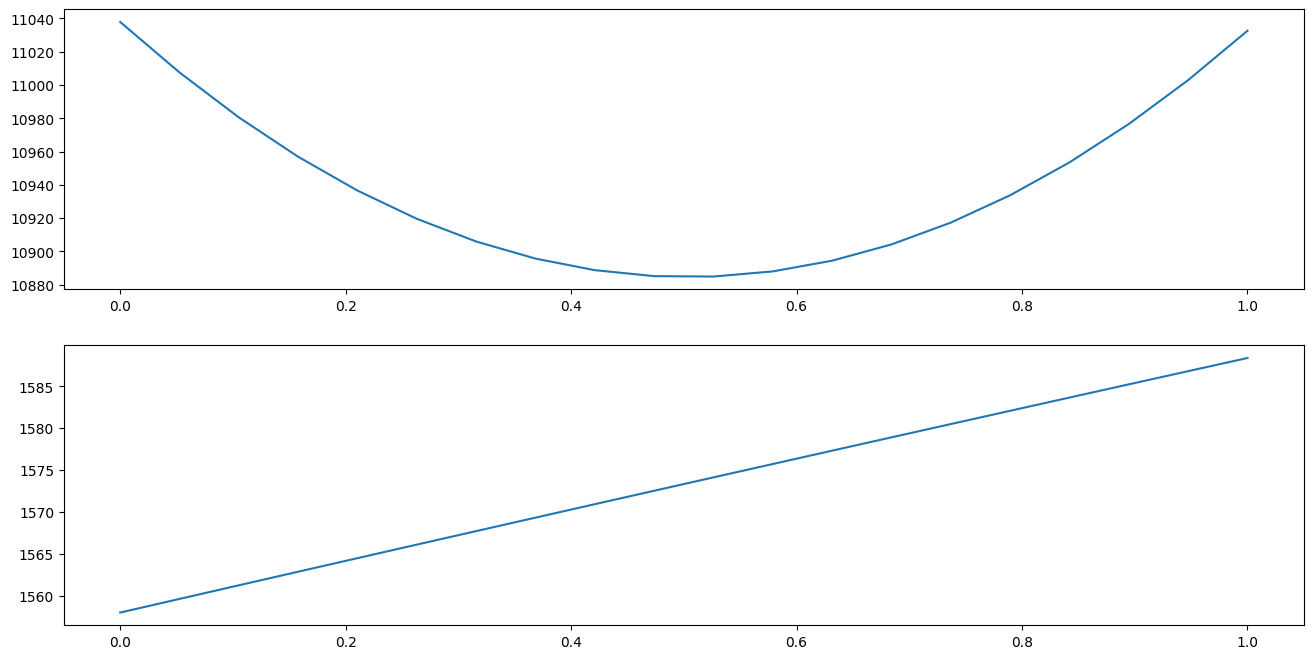

In [406]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8 ))
axes[0].plot(budget_ratios, revs)
axes[1].plot(budget_ratios, total_response);